# Riskfolio-Lib Tutorial: 
<br>__[Financionerioncios](https://financioneroncios.wordpress.com)__
<br>__[Orenji](https://www.linkedin.com/company/orenj-i/)__
<br>__[Riskfolio-Lib](https://riskfolio-lib.readthedocs.io/en/latest/)__
<br>__[Dany Cajas](https://www.linkedin.com/in/dany-cajas/)__
<a href='https://ko-fi.com/B0B833SXD' target='_blank'><img height='36' style='border:0px;height:36px;' src='https://cdn.ko-fi.com/cdn/kofi1.png?v=2' border='0' alt='Buy Me a Coffee at ko-fi.com' /></a> 

## Tutorial 40: Mean Relativistic Drawdown at Risk (RLDaR) Optimization

## 1. Downloading the data:

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import warnings

warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.4%}'.format

# Date range
start = '2016-01-01'
end = '2019-12-30'

# Tickers of assets
assets = ['JCI', 'AMZN', 'CMCSA', 'CPB', 'MO', 'APA', 'MMC', 'JPM',
          'ZION', 'AAPL', 'BAX', 'BMY', 'LUV', 'PCAR', 'TXT', 'TMO',
          'DE', 'MSFT', 'HPQ', 'SEE', 'VZ', 'CNP', 'NI', 'T', 'BA']
assets.sort()

# Downloading data
data = yf.download(assets, start = start, end = end)
data = data.loc[:,('Adj Close', slice(None))]
data.columns = assets

[*********************100%***********************]  25 of 25 completed


In [2]:
# Calculating returns

Y = data[assets].iloc[-300:,:].pct_change().dropna()

display(Y.head())

,AAPL,AMZN,APA,BA,BAX,BMY,CMCSA,CNP,CPB,DE,...,MO,MSFT,NI,PCAR,SEE,T,TMO,TXT,VZ,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2018-10-19,1.5230%,-0.3778%,0.0475%,-0.8599%,-1.4333%,-3.0011%,0.1113%,1.2968%,3.4360%,-0.8764%,...,1.6740%,0.1474%,0.6339%,-0.1823%,-0.7728%,1.1385%,-1.1144%,-1.2872%,0.4575%,-0.8025%
2018-10-22,0.6110%,1.4325%,-1.9240%,-0.0786%,-0.6334%,-6.2984%,-0.6393%,-1.1024%,0.0528%,-0.3221%,...,-1.0331%,0.8927%,-0.8661%,0.4483%,-2.8972%,-0.6085%,-0.6075%,-0.8634%,0.1457%,-3.4490%
2018-10-23,0.9427%,-1.1513%,-3.6571%,-1.6658%,-0.4202%,-0.4520%,-0.2797%,-0.5034%,0.1844%,-3.9948%,...,0.8808%,-1.3956%,0.4766%,-5.1240%,-0.0321%,1.0713%,-1.0807%,-1.8308%,4.0560%,4.0353%
2018-10-24,-3.4302%,-5.9083%,-4.5500%,1.3141%,-1.8042%,-3.5933%,-4.2917%,0.8674%,0.9995%,-4.1109%,...,0.7437%,-5.3469%,3.5178%,-4.2683%,-1.3479%,-8.0558%,-1.2403%,-4.2187%,0.3671%,-3.3065%
2018-10-25,2.1898%,7.0887%,0.4741%,2.5715%,0.5186%,0.7782%,5.0410%,-0.5733%,-1.1719%,2.1585%,...,1.3641%,5.8444%,-1.0309%,0.4914%,0.9109%,-1.2516%,4.3662%,1.3800%,-1.7242%,3.3538%


## 2. Estimating Mean Relativistic Drawdown at Risk (RLDaR) Portfolios

The Relativistic Drawdown at Risk (RLDaR) portfolio model proposed by __[Cajas (2023)](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4378498)__ shows how to optimize the RDVaR of portfolio returns in a similar way than portfolio Entropic Drawdown at Risk (EDaR). The RLDaR is a coherent risk measure that is a generalization of EDaR based on Kaniadakis entropy.

It is recommended to use MOSEK to optimize RLDaR due to RLDaR model use the power cone.

Instructions to install MOSEK are in this __[link](https://docs.mosek.com/9.2/install/installation.html)__, is better to install using Anaconda. Also you will need a license, I recommend you that ask for an academic license __[here](https://www.mosek.com/products/academic-licenses/)__.

### 2.1 Calculating the portfolio that optimize return/RLVaR ratio.

In [3]:
import riskfolio as rp
import mosek

# Building the portfolio object
port = rp.Portfolio(returns=Y)

# Calculating optimum portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu,
                  method_cov=method_cov,
                  )

# Estimate optimal portfolio:

port.solvers = ['MOSEK'] # It is recommended to use mosek when optimizing GMD
port.sol_params = {'MOSEK': {'mosek_params': {mosek.iparam.num_threads: 2}}}

kappa = 0.3
alpha = 0.2
port.kappa = kappa
port.alpha = alpha

model ='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'EDaR' # Risk measure used, this time will be Tail Gini Range
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)

,AAPL,AMZN,APA,BA,BAX,BMY,CMCSA,CNP,CPB,DE,...,MO,MSFT,NI,PCAR,SEE,T,TMO,TXT,VZ,ZION
weights,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,3.6404%,0.0000%,0.0000%,7.4021%,0.0000%,...,0.0000%,30.1616%,13.1019%,44.7419%,0.0000%,0.9521%,0.0000%,0.0000%,0.0000%,0.0000%


### 2.2 Plotting portfolio composition

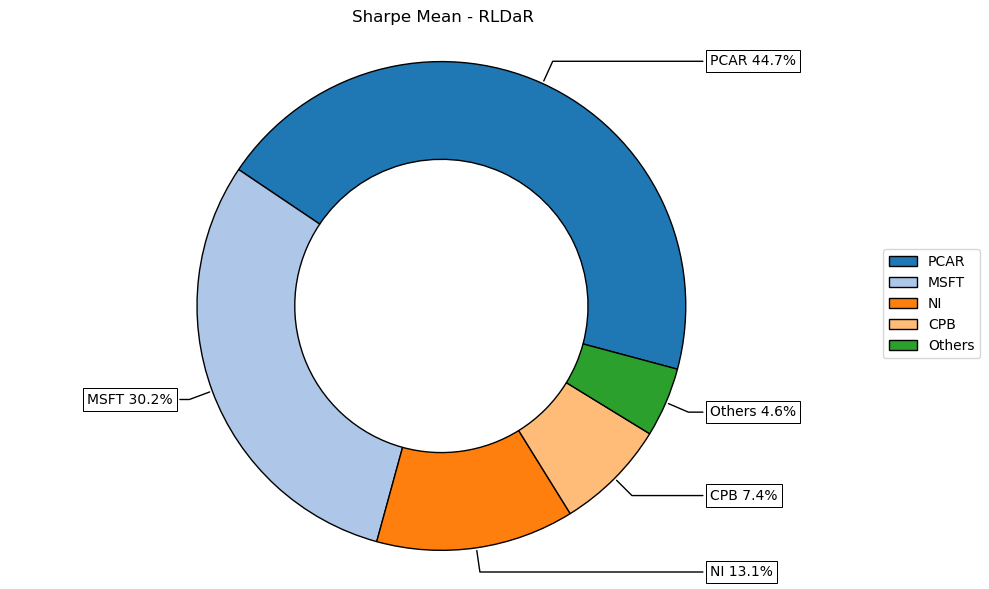

In [4]:
# Plotting the composition of the portfolio

ax = rp.plot_pie(w=w,
                 title='Sharpe Mean - RLDaR',
                 others=0.05,
                 nrow=25,
                 cmap = "tab20",
                 height=6,
                 width=10,
                 ax=None)

### 2.3 Plotting risk measures

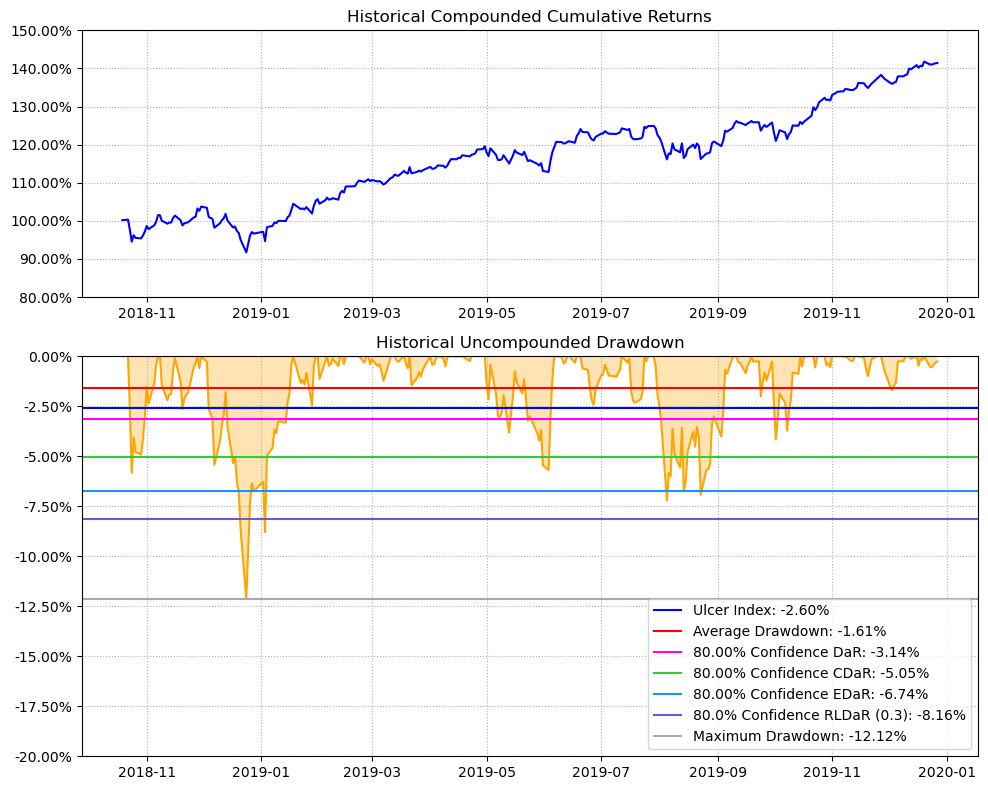

In [5]:
# Plotting the drawdown risk measures

ax = rp.plot_drawdown(returns=Y,
                      w=w,
                      alpha=alpha,
                      kappa=kappa,
                      solver='MOSEK',
                      height=8,
                      width=10,
                      height_ratios=[2, 3],
                      ax=None)

### 2.4 Calculate efficient frontier

In [6]:
points = 50 # Number of points of the frontier

frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

display(frontier.T.head())

,AAPL,AMZN,APA,BA,BAX,BMY,CMCSA,CNP,CPB,DE,...,MO,MSFT,NI,PCAR,SEE,T,TMO,TXT,VZ,ZION
0,0.0000%,0.0000%,0.0000%,0.0000%,2.5459%,6.9847%,0.0000%,14.9683%,0.0000%,0.0000%,...,0.0000%,0.0000%,32.5728%,21.0480%,0.9557%,5.7800%,0.0000%,0.0000%,15.1445%,0.0000%
1,0.0000%,0.0000%,0.0000%,0.0000%,4.7263%,8.3184%,0.0000%,6.5856%,0.0000%,0.0000%,...,0.0000%,0.0000%,36.7044%,26.7700%,7.9537%,0.7624%,0.0000%,0.0000%,8.1792%,0.0000%
2,0.0000%,0.0000%,0.0000%,0.0000%,2.8305%,8.7007%,0.0000%,3.9144%,1.5096%,0.0000%,...,0.0000%,0.0000%,38.0150%,29.5250%,9.7198%,0.7002%,0.0000%,0.0000%,5.0848%,0.0000%
3,0.0000%,0.0000%,0.0000%,0.0000%,0.3956%,9.1497%,0.0000%,0.8926%,2.9079%,0.0000%,...,0.0000%,0.0000%,40.3489%,31.7932%,11.4504%,0.5360%,0.0000%,0.0000%,2.5257%,0.0000%
4,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,9.2913%,0.0000%,0.3283%,4.5331%,0.0000%,...,0.0000%,0.0000%,39.1082%,34.3699%,11.2000%,1.1459%,0.0000%,0.0000%,0.0233%,0.0000%


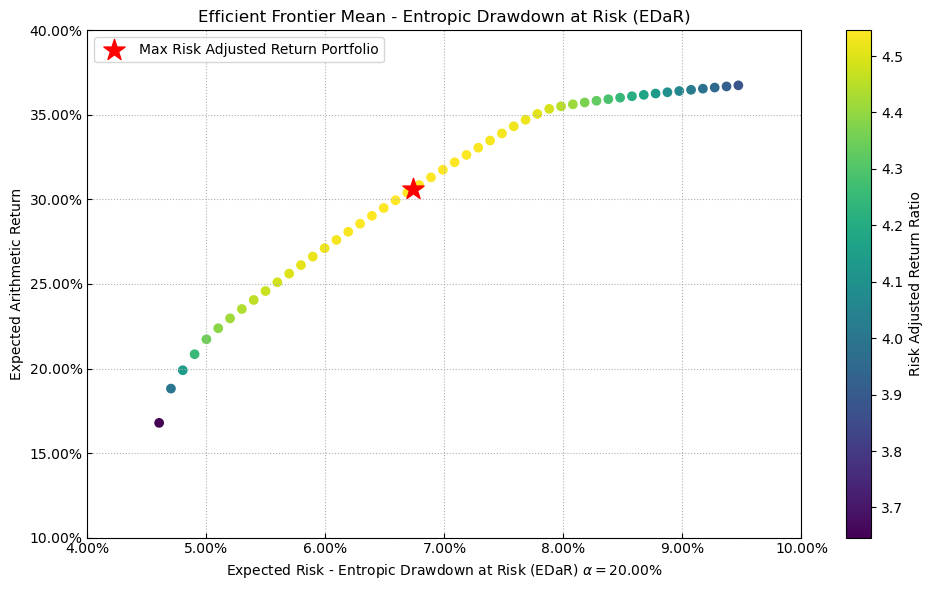

In [7]:
# Plotting the efficient frontier

label = 'Max Risk Adjusted Return Portfolio' # Title of point
mu = port.mu # Expected returns
cov = port.cov # Covariance matrix
returns = port.returns # Returns of the assets

ax = rp.plot_frontier(w_frontier=frontier,
                      mu=mu,
                      cov=cov,
                      returns=returns,
                      rm=rm,
                      rf=rf,
                      alpha=alpha,
                      kappa=kappa,
                      solver='MOSEK',
                      cmap='viridis',
                      w=w,
                      label=label,
                      marker='*',
                      s=16,
                      c='r',
                      height=6,
                      width=10,
                      ax=None)

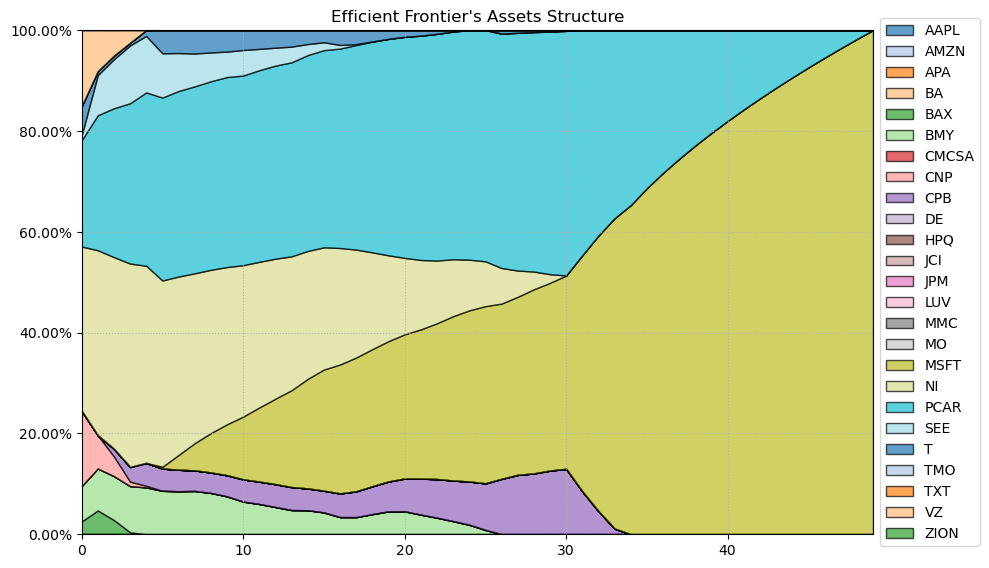

In [8]:
# Plotting efficient frontier composition

ax = rp.plot_frontier_area(w_frontier=frontier, cmap="tab20", height=6, width=10, ax=None)

## 3. Estimating Risk Parity Portfolios for Relativistic Drawdown at Risk

### 3.1 Calculating the risk parity portfolio for Relativistic Drawdown at Risk.

In [9]:
b = None # Risk contribution constraints vector

w_rp = port.rp_optimization(model=model, rm=rm, rf=rf, b=b, hist=hist)

display(w_rp.T)

,AAPL,AMZN,APA,BA,BAX,BMY,CMCSA,CNP,CPB,DE,...,MO,MSFT,NI,PCAR,SEE,T,TMO,TXT,VZ,ZION
weights,2.0960%,1.9982%,1.2990%,2.7527%,5.4417%,5.6355%,3.1832%,12.2835%,3.8515%,3.0014%,...,3.2538%,3.4735%,7.7865%,5.9182%,6.1280%,4.2823%,2.7283%,1.7643%,7.3737%,2.1190%


### 3.2 Plotting portfolio composition

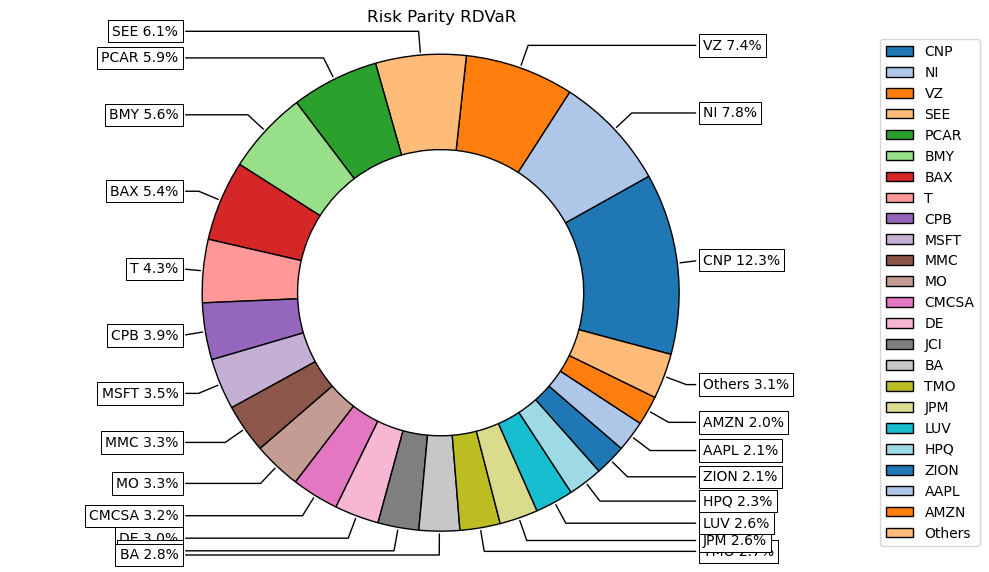

In [10]:
ax = rp.plot_pie(w=w_rp,
                 title='Risk Parity RDVaR',
                 others=0.05,
                 nrow=25,
                 cmap="tab20",
                 height=6,
                 width=10,
                 ax=None)

### 3.3 Plotting Risk Composition

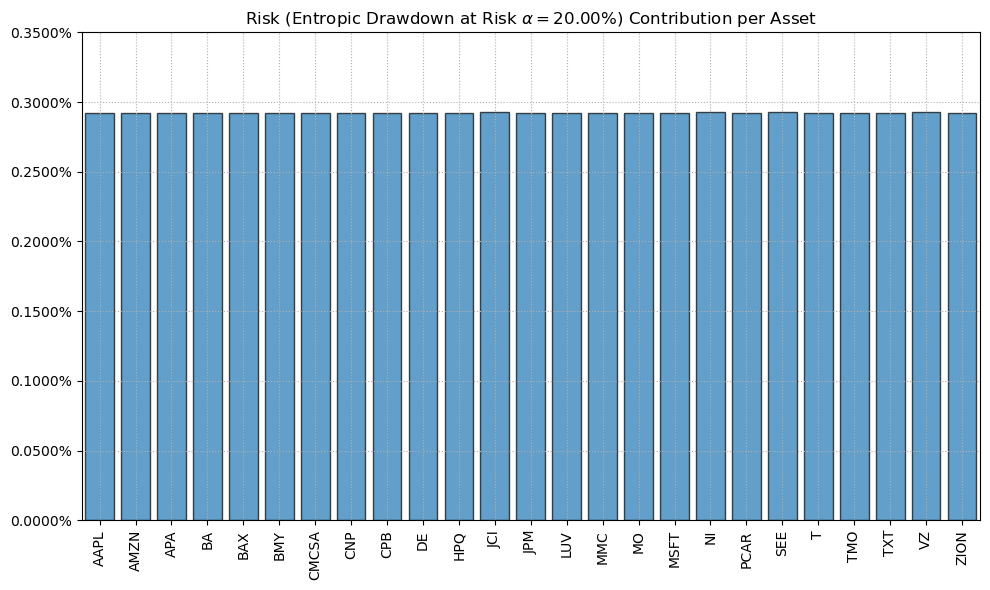

In [11]:
ax = rp.plot_risk_con(w_rp,
                      cov=port.cov,
                      returns=port.returns,
                      rm=rm,
                      rf=0,
                      alpha=alpha,
                      kappa=kappa,
                      solver='MOSEK',
                      color="tab:blue", height=6, width=10, ax=None)

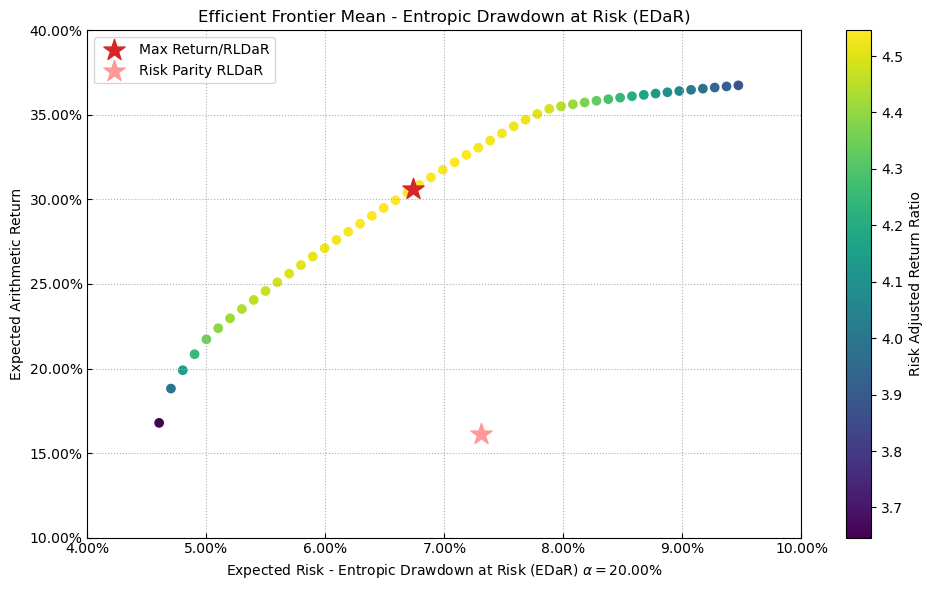

In [12]:
# Plotting the efficient frontier
ws = pd.concat([w, w_rp],axis=1)
ws.columns = ["Max Return/RLDaR", "Risk Parity RLDaR"]

mu = port.mu # Expected returns
cov = port.cov # Covariance matrix
returns = port.returns # Returns of the assets

ax = rp.plot_frontier(w_frontier=frontier,
                      mu=mu,
                      cov=cov,
                      returns=returns,
                      rm=rm,
                      rf=rf,
                      alpha=alpha,
                      kappa=kappa,
                      solver='MOSEK',
                      cmap='viridis',
                      w=ws,
                      marker='*',
                      s=16,
                      height=6,
                      width=10,
                      ax=None)